In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
# Memuat dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisasi gambar ke rentang [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Bentuk data latih:", x_train.shape)
print("Bentuk data uji:", x_test.shape)

# Definisikan nama kelas untuk visualisasi nanti
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Bentuk data latih: (60000, 28, 28, 1)
Bentuk data uji: (10000, 28, 28, 1)


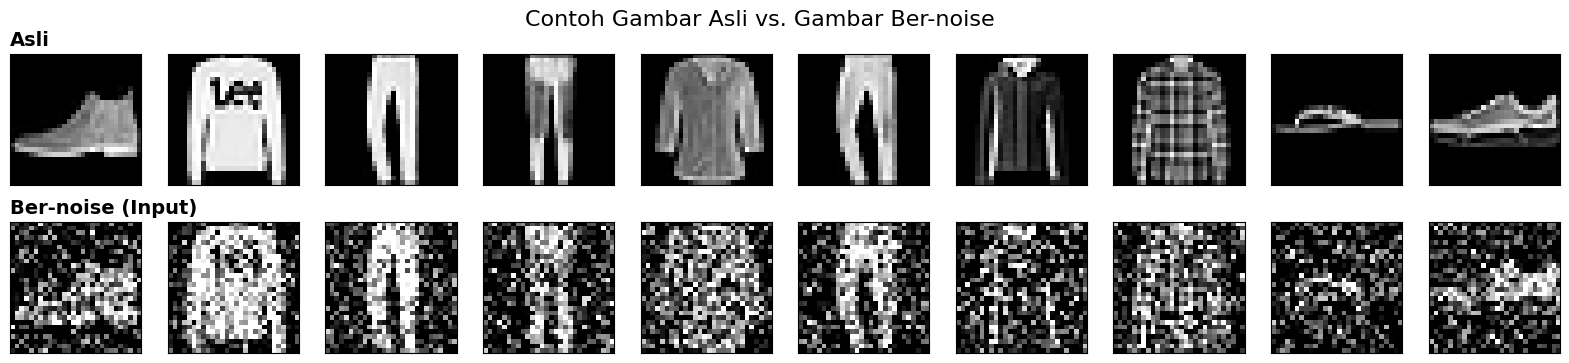

In [3]:
noise_factor = 0.4

# Menambahkan noise ke data latih dan uji
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Memastikan nilai piksel tetap dalam rentang [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Visualisasi untuk membandingkan gambar asli dan yang ber-noise
n = 10
plt.figure(figsize=(20, 4))
plt.suptitle("Contoh Gambar Asli vs. Gambar Ber-noise", fontsize=16)
for i in range(n):
    # Tampilkan gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Asli", loc='left', fontdict={'fontsize': 14, 'fontweight': 'bold'})


    # Tampilkan gambar ber-noise
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Ber-noise (Input)", loc='left', fontdict={'fontsize': 14, 'fontweight': 'bold'})

plt.show()

In [4]:
# --- ENCODER ---
input_img = keras.Input(shape=(28, 28, 1))

# Lapis 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
# Lapis 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
# Lapis 3 (Bottleneck/Latent Space)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# --- DECODER ---
# Lapis 1
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
# Lapis 2
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
# Lapis 3 (Output)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Gabungkan menjadi model autoencoder
autoencoder = keras.Model(input_img, decoded)

# Kompilasi model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Tampilkan ringkasan arsitektur
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 414ms/step - loss: 0.3522 - val_loss: 0.2959
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 401ms/step - loss: 0.2923 - val_loss: 0.2908
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 399ms/step - loss: 0.2870 - val_loss: 0.2866
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 399ms/step - loss: 0.2829 - val_loss: 0.2841
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 394ms/step - loss: 0.2816 - val_loss: 0.2824
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 396ms/step - loss: 0.2803 - val_loss: 0.2813
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 397ms/step - loss: 0.2789 - val_loss: 0.2808
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 401ms/step - loss: 0.2781 - val_loss: 0.2801
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 397ms/step - loss: 0.2770 - val_loss: 0.2793
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 398ms/step - loss: 0.2763 - val_loss: 0.2791
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 392ms/step - loss: 0.2765 - val_loss: 0.2784
Epoch 12

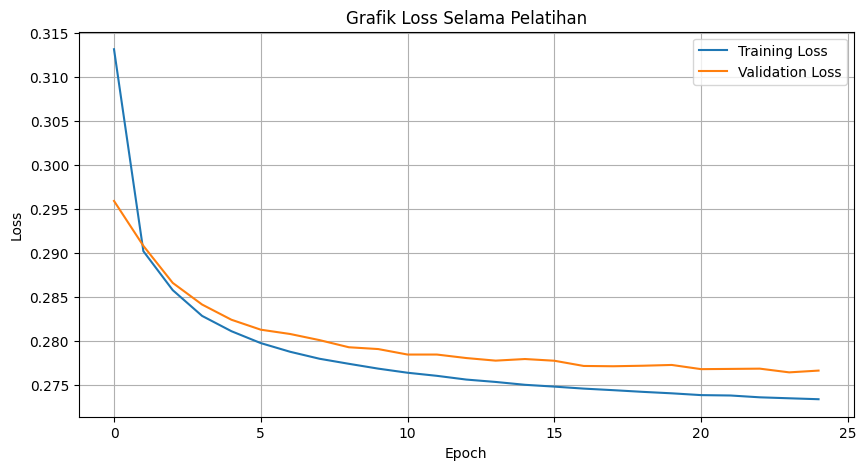

In [5]:
# Melatih autoencoder
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=25,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))


# Plot loss graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


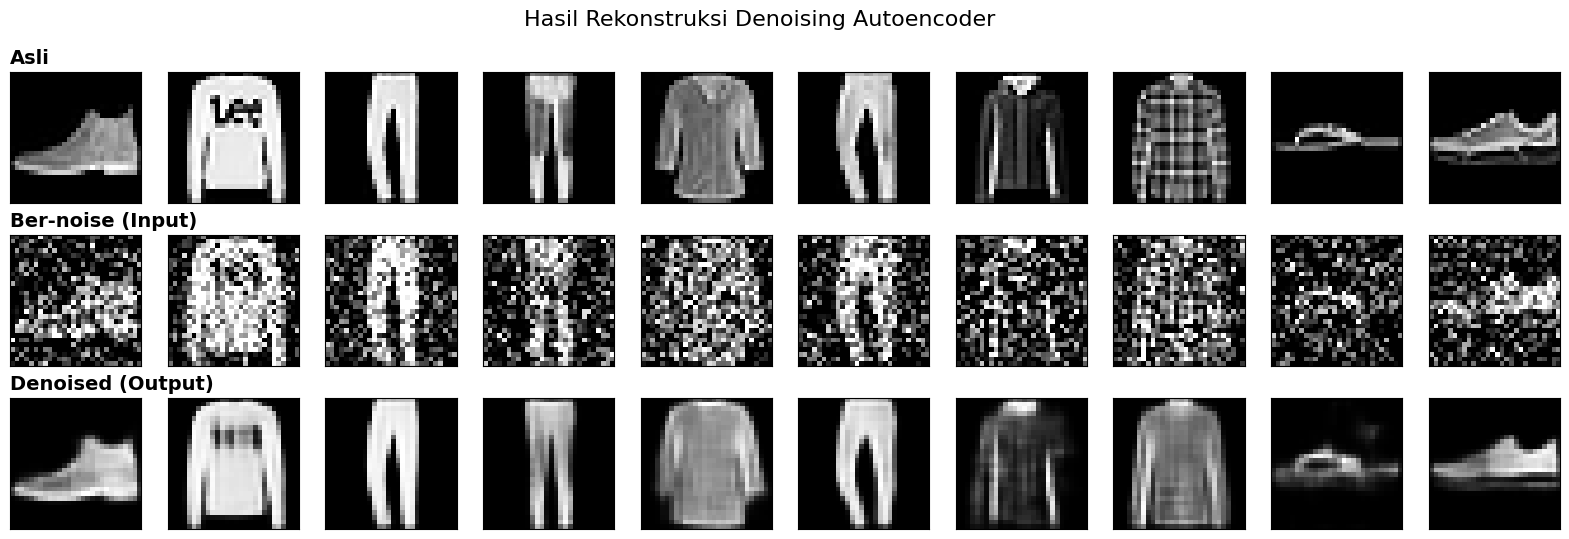

In [6]:
decoded_imgs = autoencoder.predict(x_test_noisy)

# Tampilkan hasilnya
n = 10
plt.figure(figsize=(20, 6))
plt.suptitle("Hasil Rekonstruksi Denoising Autoencoder", fontsize=16)
for i in range(n):
    # Tampilkan gambar asli
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Asli", loc='left', fontdict={'fontsize': 14, 'fontweight': 'bold'})

    # Tampilkan gambar ber-noise (input)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Ber-noise (Input)", loc='left', fontdict={'fontsize': 14, 'fontweight': 'bold'})


    # Tampilkan gambar hasil rekonstruksi (output)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Denoised (Output)", loc='left', fontdict={'fontsize': 14, 'fontweight': 'bold'})

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Bentuk vektor laten: (10000, 6272)


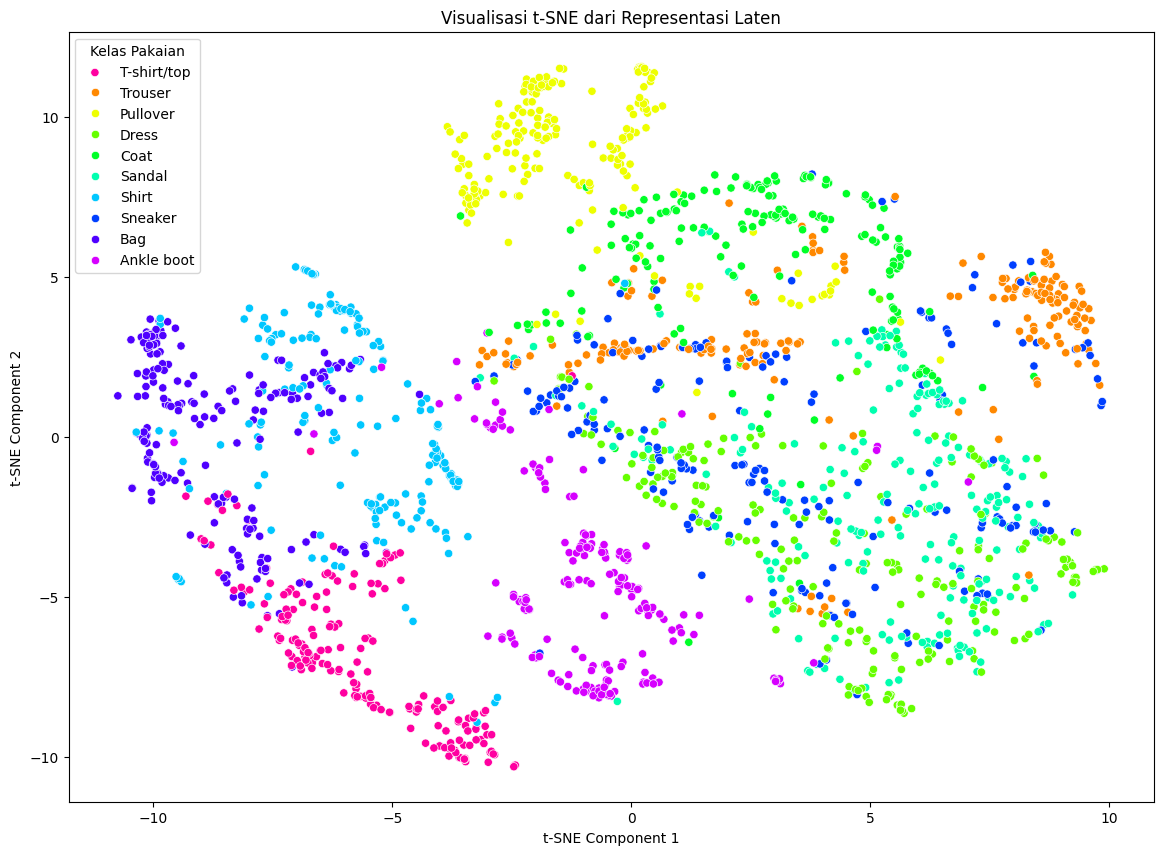

In [9]:
# Buat model encoder terpisah
encoder = keras.Model(input_img, encoded)

latent_space = encoder.predict(x_test)

# Bentuknya (batch, 7, 7, 128), kita ratakan menjadi (batch, 7*7*128)
latent_vectors = latent_space.reshape(latent_space.shape[0], -1)
print("Bentuk vektor laten:", latent_vectors.shape)

# Gunakan t-SNE untuk mereduksi dimensi menjadi 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(latent_vectors[:2000]) # Ambil 2000 sampel agar lebih cepat

# Buat DataFrame untuk visualisasi
import pandas as pd
df_tsne = pd.DataFrame(data=tsne_results, columns=['tSNE-Component-1', 'tSNE-Component-2'])
df_tsne['label'] = y_test[:2000]


# Visualisasi dengan scatter plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='tSNE-Component-1', y='tSNE-Component-2',
    hue='label',
    palette=sns.color_palette("hsv", 10),
    data=df_tsne,
    legend="full"
)
plt.title('Visualisasi t-SNE dari Representasi Laten')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Kelas Pakaian', labels=class_names)
plt.show()